In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data collection and preprocessing

In [ ]:
# Loading dataset (change path accordingly)
path_to_csv = "/content/drive/MyDrive/Colab Notebooks/DS/Projet DS/exchange_rate_with_missing.csv"
original_data = pd.read_csv(path_to_csv)

# Convert 'date' to datetime format
original_data['date'] = pd.to_datetime(original_data['date'])
original_data = original_data.set_index(original_data['date'])
data = original_data.drop(columns=['date'], axis=1)
data

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,NaN
1990-01-02,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,NaN
1990-01-03,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,NaN
1990-01-04,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,NaN
1990-01-05,0.784900,1.653000,0.861995,0.656254,NaN,0.006940,0.527426,NaN
...,...,...,...,...,...,...,...,...
2010-06-28,0.749176,1.300500,0.756802,NaN,0.149851,0.009778,0.730941,0.726401
2010-06-29,0.754290,1.302932,0.757579,NaN,0.150004,0.009830,0.734498,0.730007
2010-06-30,0.754205,1.297353,0.756024,NaN,0.149813,0.009823,0.733708,0.730727


<Axes: >

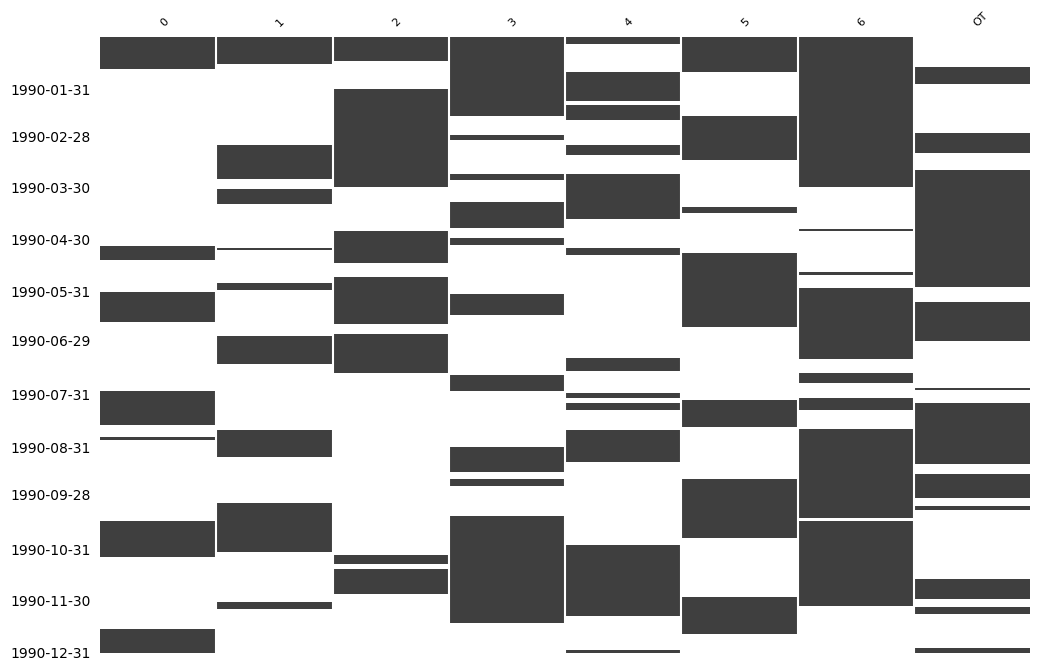

In [ ]:
# Visualizing missing values for the first recorded year (1990)
# The dark boxes indicate the presence of data for those dates while
# white spaces indicate the lack of it
msno.matrix(data[data.index.year == 1990], freq='BM', figsize=(12,8), fontsize=8, sparkline=False)


We observe missing data in each column, indicating frequent gaps in our dataset. These gaps appear to be randomly distributed without discernible patterns. Fortunately, the intervals between these gaps rarely surpass two months at a time, ensuring that imputed data adequately reflects reality for our intended purposes.

We can therefore impute the missing values with a method adequate to the time series forecasting task:

<Axes: >

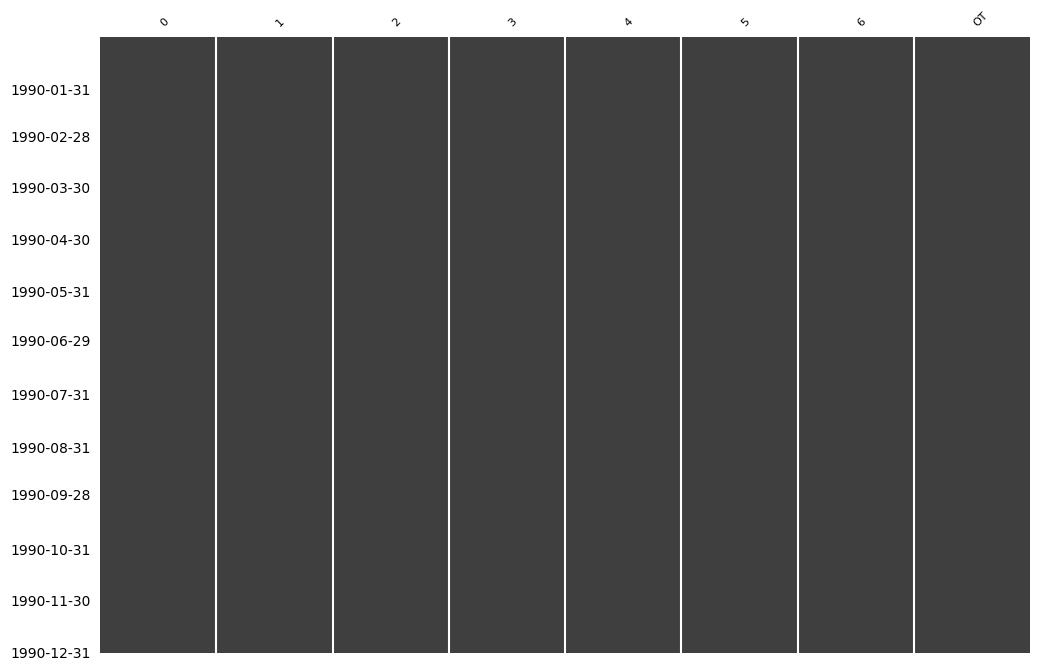

In [ ]:
# Fill missing values using forward fill followed by backward fill
data = data.ffill().bfill()

# Visualizing missing values
msno.matrix(data[data.index.year == 1990], freq='BM', figsize=(12,8), fontsize=8, sparkline=False)

Each column appears fully dark, indicating that there are no missing values left

We can now visualize every column compared to our target exchange rate: '6'

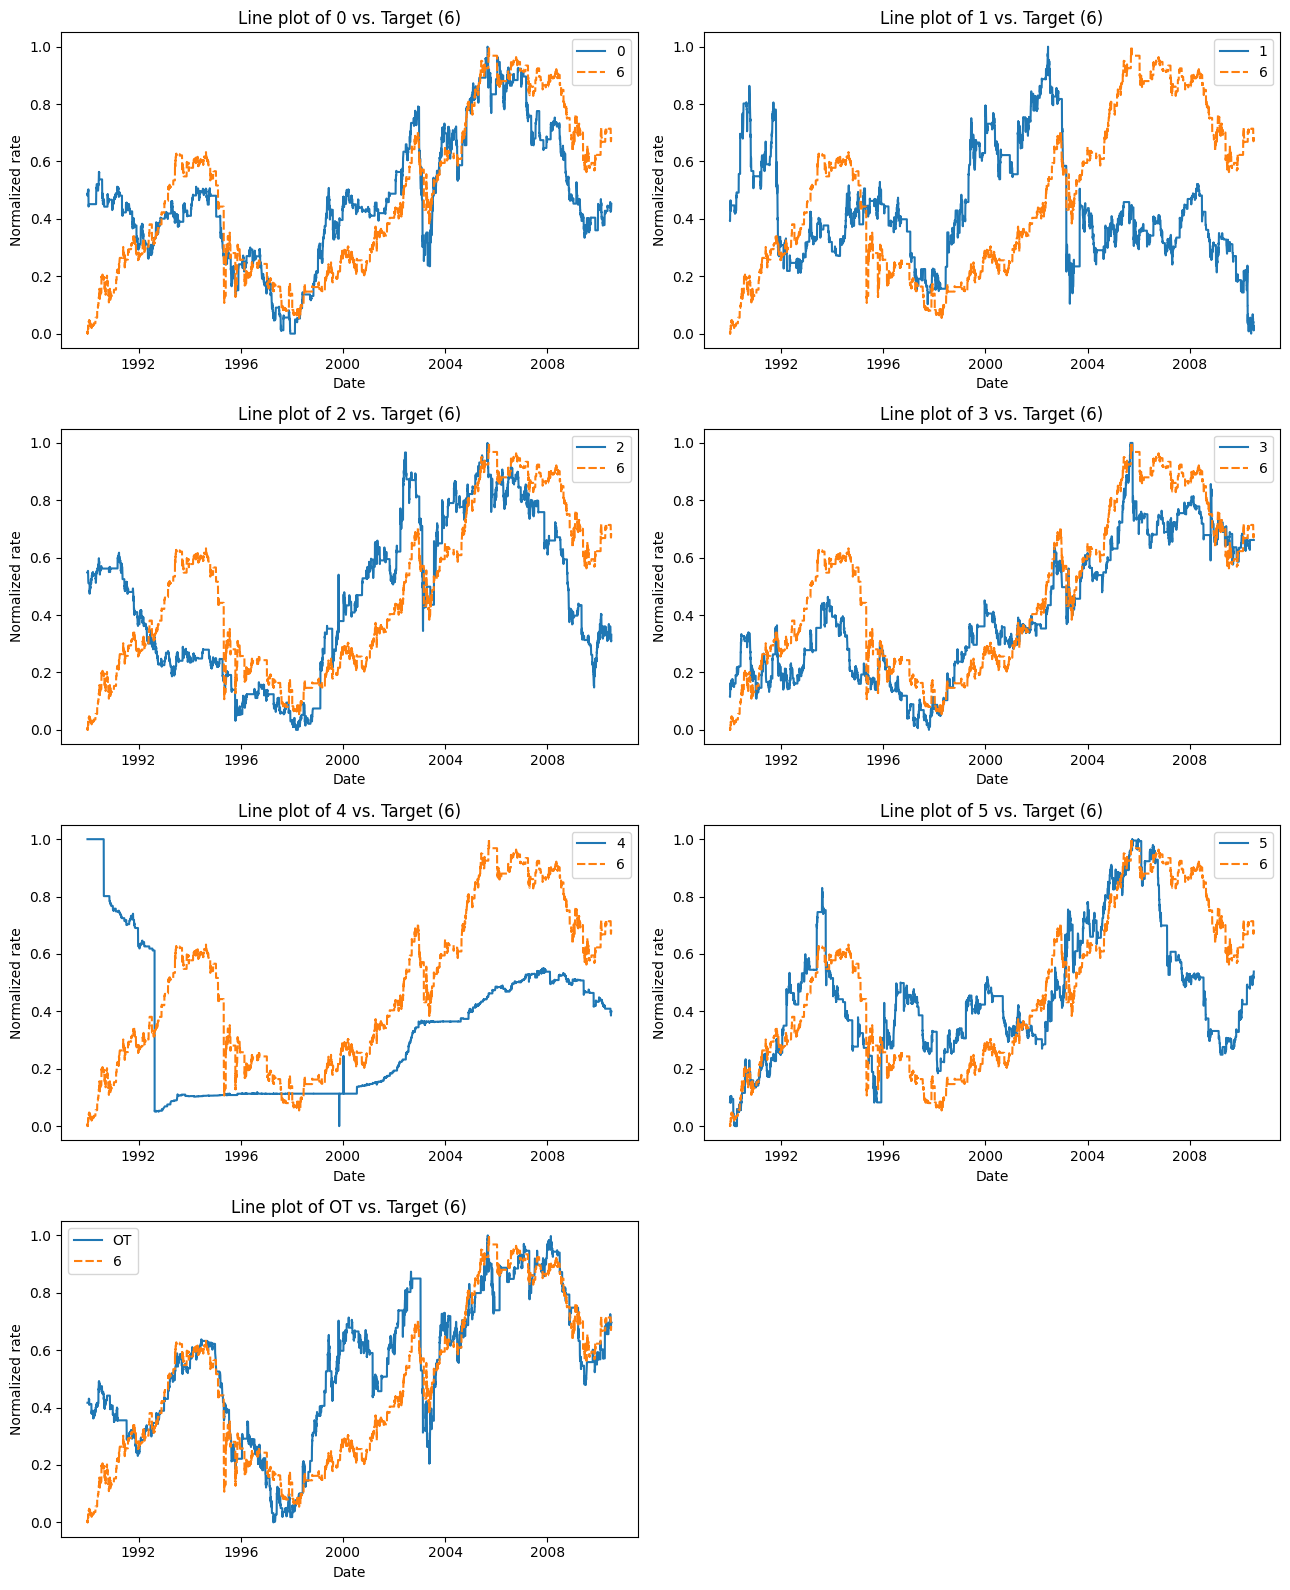

In [ ]:
def plot_comparison_graphs(data):
    # Normalize the exchange rates of each column in respect to their minimum and maximum values
    normalized_df = (data-data.min())/(data.max()-data.min())

    # Initializing graph plotting
    num_plots = len(normalized_df.columns) - 1 # Removing one for the target column
    rows = num_plots // 2 + num_plots % 2
    fig, axs = plt.subplots(rows, 2, figsize=(13, 4 * rows))

    # Flatten the axs array to iterate over it easily
    axs = axs.flatten()

    # Check if there's only one plot, not an array of axes
    if num_plots == 1:
        axs = [axs]

    # Plotting graphs comparing each column to the target
    for i, col in enumerate(['0', '1', '2', '3', '4', '5', 'OT']):
        sns.lineplot(normalized_df[[col, '6']], ax=axs[i])
        axs[i].set_title(f'Line plot of {col} vs. Target (6)')
        axs[i].set_xlabel(f'Date')
        axs[i].set_ylabel('Normalized rate')
        axs[i].legend()

    # Hide the axes for empty subplots
    for ax in axs[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_comparison_graphs(data)

We can already notice with the naked eye that some exchange rates appear to be more or less following a similar trend to our target rate.  
Unfortunately, we shouldn't solely rely on this graphic information as our eyes are subject to bias.

Let us compute the correlation values between each column and our target using the Pearson method.

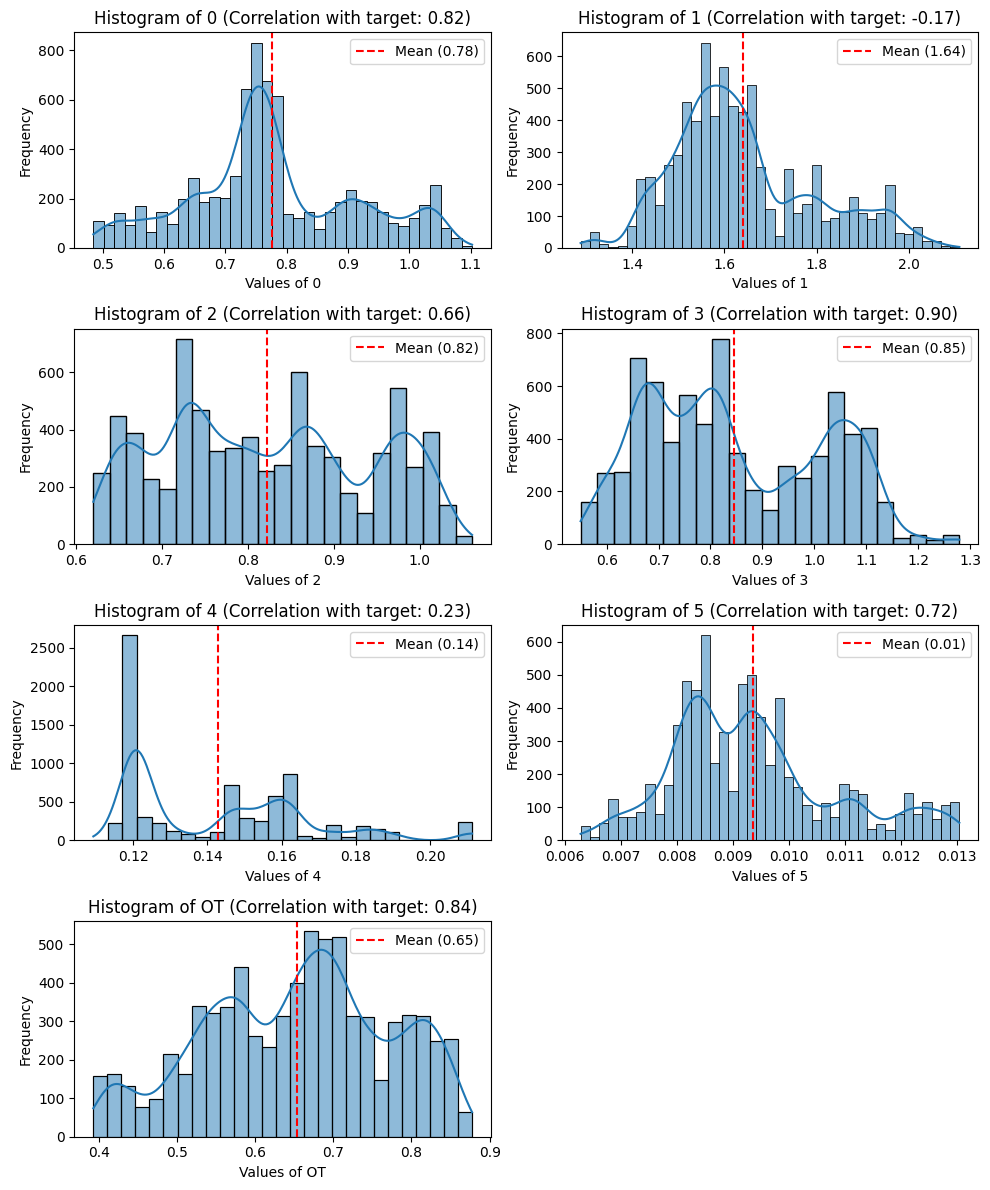

In [ ]:
def plot_correlations(data):
    # Ensure '6' is your target column
    target_correlation = data.corr()['6']

    # Drop the target itself from this series to avoid redundancy in the upcoming plot
    target_correlation = target_correlation.drop('6')

    # Plotting histograms for each column
    num_plots = len(target_correlation)
    rows = num_plots // 2 + num_plots % 2
    fig, axs = plt.subplots(rows, 2, figsize=(10, 3 * rows))

    # Flatten the axs array to iterate over it easily
    axs = axs.flatten()

    # Check if there's only one plot, not an array of axes
    if num_plots == 1:
        axs = [axs]

    # Plotting histograms comparing each column to the target alongside their correlation value
    for i, (col, correlation) in enumerate(target_correlation.items()):
        sns.histplot(data[col], kde=True, ax=axs[i])
        axs[i].set_title(f'Histogram of {col} (Correlation with target: {correlation:.2f})')
        axs[i].set_xlabel(f'Values of {col}')
        axs[i].set_ylabel('Frequency')
        # Highlight the mean position in the histogram
        axs[i].axvline(data[col].mean(), color='red', linestyle='--', label=f'Mean ({data[col].mean():.2f})')
        axs[i].legend()

    # Hide the axes for empty subplots
    for ax in axs[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return target_correlation


correlations = plot_correlations(data)

Here we can notice that the exchange rates that previously appeared similar to  our target have indeed a very high correlation coefficient.  
Considering a coefficient value of 0.7 to 0.9 as 'high', we observe 4 rates that fall into this category: '0', '3', '5' and 'OT'.

We can also trace a scatterplot to visually confirm the correlation between these 4 columns and our target:

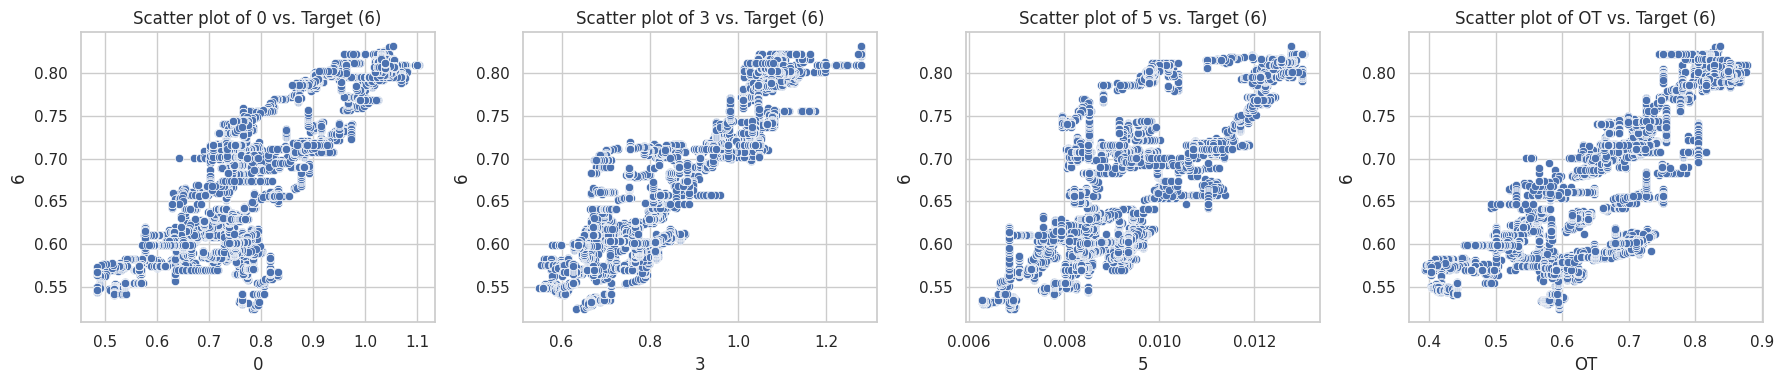

In [ ]:
def plot_scatterplot(data):
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Initialize scatter plots
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))

    # Plotting each of the top correlated columns against the target '6'
    for i, col in enumerate(['0', '3', '5', 'OT']):
        sns.scatterplot(data=data, x=col, y='6', ax=axs[i])
        axs[i].set_title(f'Scatter plot of {col} vs. Target (6)')

    plt.tight_layout()
    plt.show()

plot_scatterplot(data)

We can now visually confirm the positive correlation between the 4 columns and the target as they all seem to follow a similar trend along the y=x axis.

# Detecting outliers

The dataset representing the evolution of 8 exchange rates from 1990 to 2010, we can mainly attribute the cause of outliers to US national holidays.

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar

def get_us_holidays(start_year, end_year):
    # Generate standard US federal holidays
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=f'{start_year}-01-01', end=f'{end_year}-12-31').to_pydatetime()
    return pd.DataFrame({
        'holiday': 'us_federal_holiday',
        'ds': pd.to_datetime(holidays),
        'lower_window': 0,
        'upper_window': 1,
    })

# Assuming your data spans from 1990 to 2011
holidays = get_us_holidays(1990, 2011)

# Model training and forecasting

For the model training, we will only take into account the two columns with the highest correlation coefficient: '3' and 'OT'.  
We will be using Facebook's Prophet model for the multivariate forecasting task.

In [ ]:
# Preparing the dataframe for the model
renamed_data = data
renamed_data.columns = ['zero', 'one', 'two', 'three', 'four', 'five', 'y', 'ot']
renamed_data['ds'] = original_data.index

# Initialize model while taking into account holidays
m = Prophet(holidays=holidays)
m.fit(renamed_data)

In [ ]:
# Generate a future dataframe that starts the day after the last known data point
last_date = data['ds'].max()
future_dates = m.make_future_dataframe(periods=100, include_history=False)
future_dates = future_dates[future_dates['ds'] > last_date]

In [ ]:
# Forecast the future
forecast = m.predict(future_dates)
forecast_results = forecast[['yhat']].rename(columns={'yhat': 'Prediction'})

In [ ]:
# Reset index to use as 'Id' and save to CSV
forecast_results.rename(columns={'index': 'Id'}, inplace=True)
forecast_results = forecast_results.drop('ds', axis=1)
forecast_results['Id'] = range(len(forecast_results))

forecast_results.to_csv('prophet_forecast1.csv', index=False)

    Prediction  Id
95    0.721688  95
96    0.721726  96
97    0.721570  97
98    0.721391  98
99    0.721321  99


<Axes: >

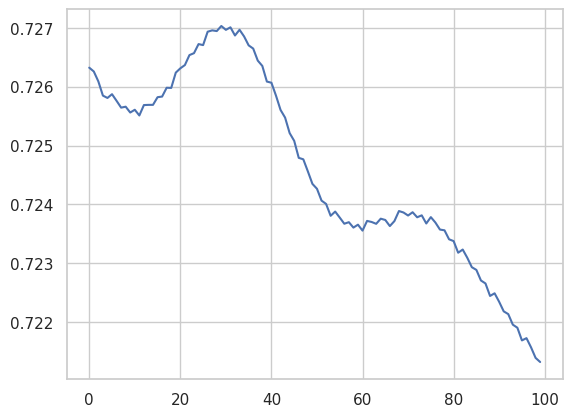

In [ ]:
# Display the last few rows to confirm
print(forecast_results.tail())

# Visualize the predicted values
forecast_results['Prediction'].plot()